### 内容：
1. 请实现非极大值抑制(NMS)，并使用NMS对原始人脸框进行筛选；
2. 请尝试调整NMS中使用的置信度，研究不同置信度对人脸框筛选会造成什么影响。
备注：作业所提供的人脸框(face_box)是从MTCNN的R-net与O-net中获得的。

<class 'numpy.ndarray'>


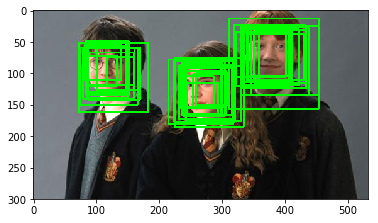

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 读入图片，录入原始人脸框（[x1, y1, x2, y2, score]）
image = cv2.imread('image.jpg')
face_boxs = np.array([[238, 82, 301, 166, 0.99995422], [239, 86, 300, 166, 0.99997818], [341, 26, 412, 112, 0.99781644],
                    [239, 83, 301, 166, 0.99990737], [ 85, 49, 152, 132, 0.99995887], [340, 25, 411, 112, 0.99890125],
                    [341, 26, 412, 111, 0.99748683], [ 85, 49, 151, 130, 0.99962735], [ 84, 48, 151, 130, 0.99987411],
                    [340, 28, 409, 112, 0.99846846], [341, 28, 410, 111, 0.99695492], [340, 26, 410, 110, 0.99970192],
                    [341, 27, 410, 111, 0.99794656], [238, 84, 299, 165, 0.99928051], [ 84, 49, 151, 131, 0.99978763],
                    [ 85, 49, 148, 131, 0.99988151], [238, 81, 305, 168, 0.99999976], [340, 26, 410, 112, 0.99981469],
                    [ 84, 52, 153, 134, 0.99992657], [336, 23, 411, 114, 0.99238223], [238, 83, 300, 164, 0.99994004],
                    [236, 83, 301, 164, 0.99982053], [340, 25, 411, 112, 0.9982546 ], [ 85, 50, 150, 139, 0.99916756],
                    [ 85, 49, 151, 131, 0.99978501], [232, 87, 317, 173, 0.99997389], [330, 26, 438, 134, 0.9898662 ],
                    [236, 96, 306, 166, 0.99976283], [359, 38, 431, 110, 0.98443735], [351, 31, 434, 115, 0.99634606],
                    [225, 75, 335, 185, 0.99919599], [311, 13, 454, 156, 0.92719758], [ 87, 59, 170, 142, 0.99837035],
                    [259,100, 309, 150, 0.92693377], [241, 91, 316, 166, 0.99995005], [ 79, 60, 161, 141, 0.99849546],
                    [ 82, 53, 140, 111, 0.96095043], [ 72, 52, 183, 162, 0.96566218], [341, 38, 406, 104, 0.99826789],
                    [254,101, 306, 153, 0.90867722], [319, 23, 402, 106, 0.99615687], [335, 30, 423, 119, 0.999345  ],
                    [117, 74, 161, 119, 0.92760825], [215, 78, 318, 181, 0.99981409], [101, 60, 169, 127, 0.99795973],
                    [238,104, 287, 153, 0.96899307], [245,115, 294, 164, 0.89920408], [243, 88, 330, 176, 0.99885798],
                    [ 86, 67, 160, 141, 0.98279655], [234, 90, 299, 155, 0.99896216], [ 75, 59, 166, 150, 0.98545951],
                    [224, 80, 321, 177, 0.99998498], [ 87, 56, 149, 118, 0.99664032], [ 85, 72, 133, 120, 0.78204125],
                    [346, 25, 455, 134, 0.8496629 ], [334, 24, 434, 124, 0.99889356], [322, 35, 407, 120, 0.99624914]])

# 将原始人脸框绘制在人脸图像上
image_for_all_box = image.copy()
for box in face_boxs:
    x1, y1, x2, y2, score = int(box[0]), int(box[1]), int(box[2]), int(box[3]), box[4]
    image_for_all_box = cv2.rectangle(image_for_all_box, (x1, y1), (x2, y2), (0,255,0), 2)
# cv2.imshow('image_for_all_box', image_for_all_box)
plt.imshow(cv2.cvtColor(image_for_all_box, cv2.COLOR_BGR2RGB))
plt.show()

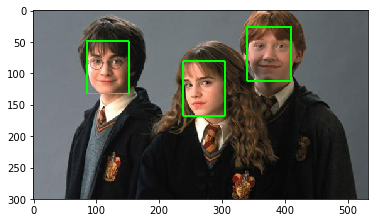

In [6]:
# 定义一个nms函数
def nms(dets, thresh):
    '''
    input：
        dets: [x1, y1, x2, y2, score]
        thresh: float
    output：
        index
    '''
    #x1、y1、x2、y2、以及score赋值
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    # 每一个候选框的面积
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    # order是按照score降序排序的
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        # 计算当前概率最大矩形框与其他矩形框的相交框的坐标，会用到numpy的broadcast机制，得到的是向量
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        # 计算相交框的面积,注意矩形框不相交时w或h算出来会是负数，用0代替
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        # 计算重叠度IOU：重叠面积/（面积1+面积2-重叠面积）
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        # 找到重叠度不高于阈值的矩形框索引
        inds = np.where(ovr <= thresh)[0]
        # 将order序列更新，由于前面得到的矩形框索引要比矩形框在原order序列中的索引小1，所以要把这个1加回来
        order = order[inds + 1]
    return keep

# 使用nms对人脸框进行筛选
keep = nms(face_boxs, thresh=0.2)
nms_face_boxs = face_boxs[keep]

# 将筛选过后的人脸框绘制在人脸图像上
image_for_nms_box = image.copy()
for box in nms_face_boxs:
    x1, y1, x2, y2, score = int(box[0]), int(box[1]), int(box[2]), int(box[3]), box[4]
    image_for_nms_box = cv2.rectangle(image_for_nms_box, (x1, y1), (x2, y2), (0,255,0), 2)
# cv2.imshow('image_for_nms_box', image_for_nms_box)
plt.imshow(cv2.cvtColor(image_for_nms_box, cv2.COLOR_BGR2RGB))
plt.show()
# cv2.waitKey()
# cv2.destroyAllWindows()